# Hi coiled


<img src="https://docs.dask.org/en/latest/_static/images/dask-horizontal-white.svg" style="width:25%" align="left">

<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" width="30%" align="right">

## What are we doing?

> Eastern Tropical Pacific corals have evolved to live in these extreme conditions, mostly in genetic isolation from western Pacific corals, which marks them as resilient to climate change
[2] and thus good candidates for coral restoration. Maximizing the geographic scope of restoration depends on
designing a network of restoration sites that considers where (1) environmental conditions favor coral resilience,
and (2) where restoration takes advantage of larval connectivity to maximize recruitment potential. 

<img src="mpa.png" width="50%" align="center">



<img src="connectivity.png" width="80%">

---
## But what are we really doing? 


1. Run ocean model (FORTRAN); save a lot of output; make sure its sensible
2. Use saved flow fields to move particles (larvae) around.
3. ????
4. Conservation! and papers!

---
## We need scalable "post-processing" analysis software

<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" width="30%">



Analyzing large nd-arrays making use of associated metadata

https://xarray.pydata.org

    Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy
    Xarray is inspired by and borrows heavily from pandas, the popular data analysis package focused on labelled tabular data.

---

## What you'll learn

1. Xarray lets use metadata to make you analysis code more readable and intuitive
1. Xarray wraps dask to let you parallelize your analysis easily
1. Xarray provides an accessor or plugin interface that allows other packages to build on top of xarray objects

---

## Setup: HPC / Cheyenne / Casper / dask_jobqueue

In [ ]:
import dask_jobqueue

cluster = dask_jobqueue.SLURMCluster(
    cores=1,
    processes=1,
    memory="25GB",
    walltime="08:00:00",
    project="NCGD0011",
    scheduler_options=dict(dashboard_address=":9797"),
)

cluster.scale(12)
cluster

In [72]:
cluster

In [78]:
%%bash
squeue -u dcherian

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
           5904585       dav dask-wor dcherian  R    1:09:22      1 casper12 
           5904586       dav dask-wor dcherian  R    1:09:22      1 casper10 
           5904587       dav dask-wor dcherian  R    1:09:22      1 casper10 
           5904588       dav dask-wor dcherian  R    1:09:22      1 casper10 
           5904589       dav dask-wor dcherian  R    1:09:22      1 casper10 
           5904590       dav dask-wor dcherian  R    1:09:22      1 casper03 
           5904591       dav dask-wor dcherian  R    1:09:22      1 casper03 
           5904592       dav dask-wor dcherian  R    1:09:22      1 casper03 
           5904593       dav dask-wor dcherian  R    1:09:22      1 casper03 
           5904594       dav dask-wor dcherian  R    1:09:22      1 casper03 
           5904595       dav dask-wor dcherian  R    1:09:22      1 casper03 
           5904596       dav dask-wor dcherian  R    1:0

In [79]:
%matplotlib inline

import dask
import distributed

import matplotlib as mpl
import numpy as np
import pandas as pd

import xarray as xr

xr.set_options(keep_attrs=True)

In [76]:
client = distributed.Client(cluster)
client

Client Scheduler: tcp://10.12.205.19:38701 Dashboard: /proxy/9797/status,Cluster Workers: 12 Cores: 12 Memory: 300.00 GB


## What is the data

A large collection of netCDF files; one per day (average over a day) for a year. At 2GB per file; this is 720 GB.

A lot of geoscience datasets look like this

In [ ]:
dirname = "/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/*_2013_*"

In [80]:
ls /glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/*_2013_*

/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_001.nc
/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_002.nc
/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_003.nc
/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_004.nc
/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_005.nc
/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_006.nc
/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_007.nc
/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_008.nc
/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_009.nc
/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_010.nc
/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_011.nc
/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_012.nc
/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_013.nc
/glade/scratch/bachman/ET

Our production run is going to be 25 years with approx 34TB storage budgeted

## Read one file as an Xarray Dataset

In [81]:
ds = xr.open_dataset(
    "/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/ocean_daily__2013_001.nc",
    chunks=-1,  # dask.array chunks
)
ds

<xarray.Dataset>
Dimensions:     (nv: 2, time: 1, xh: 1000, xq: 1001, yh: 900, yq: 901, zl: 140)
Coordinates:
  * xh          (xh) float64 235.0 235.1 235.1 235.2 ... 284.8 284.9 284.9 285.0
  * yh          (yh) float64 -14.97 -14.93 -14.88 -14.82 ... 29.88 29.92 29.98
  * zl          (zl) float64 1.25 3.75 6.25 ... 6.074e+03 6.324e+03 6.475e+03
  * time        (time) object 2013-01-01 12:00:00
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 235.0 235.1 235.1 235.2 ... 284.9 284.9 284.9 285.0
  * yq          (yq) float64 -15.0 -14.95 -14.9 -14.85 ... 29.85 29.9 29.95 30.0
Data variables:
    thetao      (time, zl, yh, xh) float32 dask.array<chunksize=(1, 140, 900, 1000), meta=np.ndarray>
    so          (time, zl, yh, xh) float32 dask.array<chunksize=(1, 140, 900, 1000), meta=np.ndarray>
    uo          (time, zl, yh, xq) float32 dask.array<chunksize=(1, 140, 900, 1001), meta=np.ndarray>
    vo          (time, zl, yq, xh) float32 dask.array<chunksize=(1, 140, 901, 1000), meta=np.ndarray>
    rlntds      (time, yh, xh) float32 dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    hflso       (time, yh, xh) float32 dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    hfsso       (time, yh, xh) float32 dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    rsntds      (time, yh, xh) float32 dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    hfds        (time, yh, xh) float32 dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    taux        (time, yh, xq) float32 dask.array<chunksize=(1, 900, 1001), meta=np.ndarray>
    tauy        (time, yq, xh) float32 dask.array<chunksize=(1, 901, 1000), meta=np.ndarray>
    friver      (time, yh, xh) float32 dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    filename:   ocean_daily__2013_001.nc
    title:      MOM6 diagnostic fields table for CESM case: ETP.003
    grid_type:  regular
    grid_tile:  N/A

## What's in a Dataset? DataArray = nd-array + metadata

In [ ]:
ds.thetao

## Looking at your data is easy

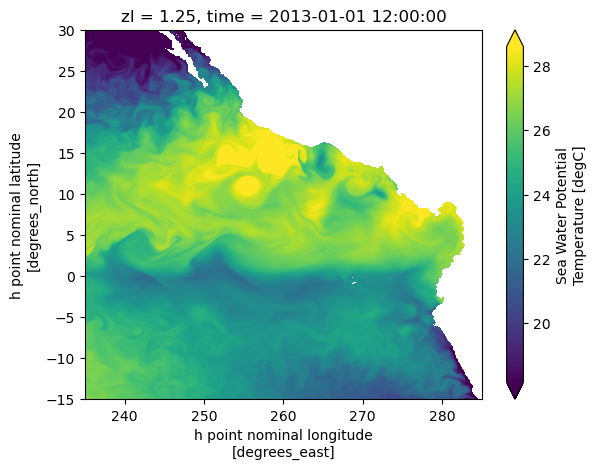

In [83]:
# SST plot
ds.thetao.isel(zl=0).plot(robust=True)

## Operations in "label space"

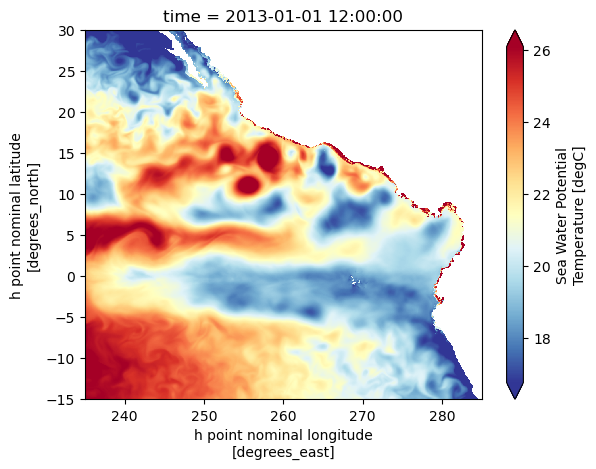

In [84]:
# vertical average temperature in top 100m
# selection in "label space"

# this is amazing!
ds.thetao.sel(zl=slice(100)).mean("zl").plot(robust=True, cmap=mpl.cm.RdYlBu_r)

## Automatic broadcasting: no more np.newaxis

In [85]:
# anomaly w.r.t surface value

ds.thetao - ds.thetao.isel(zl=0)

<xarray.DataArray 'thetao' (time: 1, zl: 140, yh: 900, xh: 1000)>
dask.array<sub, shape=(1, 140, 900, 1000), dtype=float32, chunksize=(1, 140, 900, 1000), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 235.0 235.1 235.1 235.2 ... 284.8 284.9 284.9 285.0
  * yh       (yh) float64 -14.97 -14.93 -14.88 -14.82 ... 29.88 29.92 29.98
  * zl       (zl) float64 1.25 3.75 6.25 8.75 ... 6.074e+03 6.324e+03 6.475e+03
  * time     (time) object 2013-01-01 12:00:00
Attributes:
    long_name:      Sea Water Potential Temperature
    units:          degC
    cell_methods:   area:mean zl:mean yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

## Xarray objects are dask collections!

In [86]:
persisted,  = dask.persist(ds[["thetao", "so"]])
persisted

<xarray.Dataset>
Dimensions:  (time: 1, xh: 1000, yh: 900, zl: 140)
Coordinates:
  * yh       (yh) float64 -14.97 -14.93 -14.88 -14.82 ... 29.88 29.92 29.98
  * time     (time) object 2013-01-01 12:00:00
  * xh       (xh) float64 235.0 235.1 235.1 235.2 ... 284.8 284.9 284.9 285.0
  * zl       (zl) float64 1.25 3.75 6.25 8.75 ... 6.074e+03 6.324e+03 6.475e+03
Data variables:
    thetao   (time, zl, yh, xh) float32 dask.array<chunksize=(1, 140, 900, 1000), meta=np.ndarray>
    so       (time, zl, yh, xh) float32 dask.array<chunksize=(1, 140, 900, 1000), meta=np.ndarray>
Attributes:
    filename:   ocean_daily__2013_001.nc
    title:      MOM6 diagnostic fields table for CESM case: ETP.003
    grid_type:  regular
    grid_tile:  N/A

In [87]:
client.cancel(persisted)

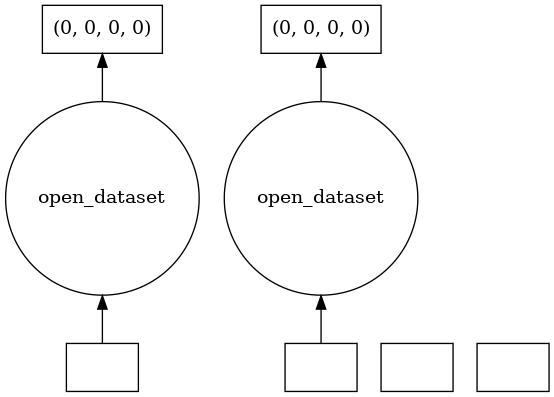

In [88]:
dask.visualize(ds[["thetao", "so"]])

## xarray can wrap other array types, not just numpy & dask

<img src="https://sparse.pydata.org/en/stable/_images/logo.png" style="width:12%">

**pydata/sparse** : sparse arrays http://sparse.pydata.org

<img src="https://raw.githubusercontent.com/cupy/cupy.dev/master/images/cupy_logo.png" style="width:22%">

**cupy** : GPU arrays http://cupy.chainer.org

<img src="https://pint.readthedocs.io/en/stable/_images/logo-full.jpg" style="width:10%">

**pint** : unit-aware computations https://pint.readthedocs.org &
https://github.com/xarray-contrib/pint-xarray


## Read entire set of files as an Xarray Dataset

Xarray's ``open_mfdataset`` wraps a common pattern for reading multiple files with ``dask.delayed``:

```
open_tasks = [dask.delayed(xr.open_dataset)(f) for f in file_names]
datasets = dask.compute(open_tasks)  # get a list of xarray.Datasets
combined = xr.combine_nested(datasets)  # or some combination of concat, merge
```

In [89]:
ds = xr.open_mfdataset(
    "/glade/scratch/bachman/ETP.011/2013_with_ePBL_FFH/*_2013_*", # directory name
    parallel=True,  # parallelize using dask delayed
    chunks={"xh": 400, "xq": 400},  # dask.array chunks; 1 chunk per file
)

ds["time"] = ds.indexes["time"].to_datetimeindex()  # ignore
ds

<ipython-input-89-37dc95dd951d>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds["time"] = ds.indexes["time"].to_datetimeindex()  # ignore


,Array,Chunk
Bytes,183.96 GB,201.60 MB
Shape,"(365, 140, 900, 1000)","(1, 140, 900, 400)"
Count,2555 Tasks,1095 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,183.96 GB,201.60 MB
Shape,"(365, 140, 900, 1000)","(1, 140, 900, 400)"
Count,2555 Tasks,1095 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


This is an xarray Dataset composed of xarray DataArrays, which in turn wrap dask arrays (which in turn have numpy arrays as chunk type)

In [ ]:
ds.thetao

## Simple validation exercise: Compare sea surface temperature to satellite observations

We will compare monthly means

In [90]:
monthly_sst = (
    ds.thetao  # temperature
    .isel(zl=0)  # pick surface level
    .resample(time="M").mean()  # monthly means
)
monthly_sst  # monthly mean sea surface temperature

<xarray.DataArray 'thetao' (time: 12, yh: 900, xh: 1000)>
dask.array<stack, shape=(12, 900, 1000), dtype=float32, chunksize=(1, 900, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2013-01-31 2013-02-28 ... 2013-12-31
  * yh       (yh) float64 -14.97 -14.93 -14.88 -14.82 ... 29.88 29.92 29.98
  * xh       (xh) float64 235.0 235.1 235.1 235.2 ... 284.8 284.9 284.9 285.0
    zl       float64 1.25
Attributes:
    long_name:      Sea Water Potential Temperature
    units:          degC
    cell_methods:   area:mean zl:mean yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

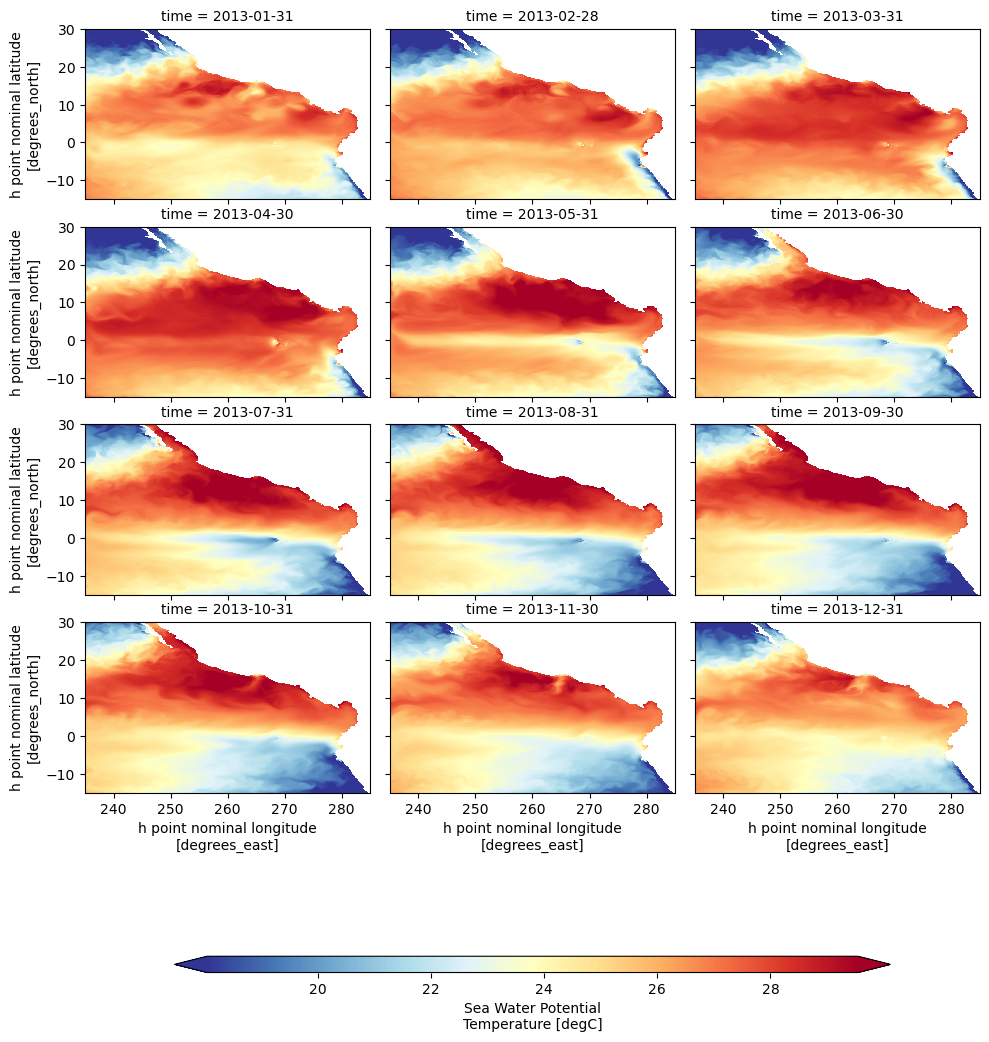

In [91]:
monthly_sst.plot(
    col="time",  # creates subplots, one per time instant
    col_wrap=3,  # 3 subplots per row
    robust=True,
    cmap=mpl.cm.RdYlBu_r,
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
)

## Read satellite obs

In [ ]:
satsst = xr.open_mfdataset(
    "/glade/u/home/dcherian/pump/obs/oisst/*2013*.nc", 
    chunks={"time": 120}
).sst
satsst

In [ ]:
satsst.isel(time=1).plot()

## Subset satellite data to model domain using cf_xarray

Annoyingly the dimension names are different

In [ ]:
print(ds.thetao.dims)
print(satsst.dims)

In [ ]:
import cf_xarray #.cf is an "accessor" which lets us extend xarray functionality

ds.thetao.cf["latitude"]

In [ ]:
satsst.cf["latitude"]

In [ ]:
lon = ds.thetao.cf["longitude"]
lat = ds.thetao.cf["latitude"]

selector = {
    "longitude": slice(round(lon.min().item()), round(lon.max().item())),
    "latitude": slice(round(lat.min().item()), round(lat.max().item())),
}
selector

In [ ]:
# subset to domain using cf.sel
satsst.cf.sel(selector)

In [ ]:
monthly_satsst = (
    satsst
    .cf.sel(selector)  # subset to domain
    .cf.rename_like(ds.thetao)  # rename dimension names
    .resample(time="M").mean()  # monthly mean
)
monthly_satsst

## What is the error?

First, these two datasets are on different grids. The satellite at 1/4° (≈25km); model at 1/20° (≈ 5km). 

In [ ]:
print(monthly_satsst.sizes)
print(monthly_sst.sizes)

Luckily we can use coarsen to line these up

In [ ]:
monthly_sst_025deg = (
    monthly_sst
    .coarsen(yh=5, xh=5, boundary="trim")  # wraps dask.array.Array.coarsen
    .mean()
    .reindex_like(monthly_satsst, tolerance=0.1, method="nearest")  # ignore small differences in lat/lon locations
)
monthly_sst_025deg

In [ ]:
error = monthly_sst_025deg - monthly_satsst
error.plot(
    col="time",
    col_wrap=3,
    robust=True,
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
)

## More advanced: Xarray + Dask + Numba

Easily extend label-unaware functions to work on Xarray's labelled objects

In [95]:
from numba import vectorize

@vectorize(["float32(float32, float32)"], cache=True, nopython=True)
def eos(S, theta):
    # --- Define constants (Table 1 Column 4, Wright 1997, J. Ocean Tech.)---
    a0 = 7.057924e-4
    a1 = 3.480336e-7
    a2 = -1.112733e-7

    b0 = 5.790749e8
    b1 = 3.516535e6
    b2 = -4.002714e4
    b3 = 2.084372e2
    b4 = 5.944068e5
    b5 = -9.643486e3

    c0 = 1.704853e5
    c1 = 7.904722e2
    c2 = -7.984422
    c3 = 5.140652e-2
    c4 = -2.302158e2
    c5 = -3.079464

    # To compute potential density keep pressure p = 100 kpa
    # S in standard salinity units psu, theta in DegC, p in pascals

    p = 100000.0
    alpha0 = a0 + a1 * theta + a2 * S
    p0 = (
        b0
        + b1 * theta
        + b2 * theta ** 2
        + b3 * theta ** 3
        + b4 * S
        + b5 * theta * S
    )
    lambd = (
        c0
        + c1 * theta
        + c2 * theta ** 2
        + c3 * theta ** 3
        + c4 * S
        + c5 * theta * S
    )

    pot_dens = (p + p0) / (lambd + alpha0 * (p + p0))

    return pot_dens

In [96]:
def pdens(S, theta):
    """ Wright 97 EOS from https://mom6-analysiscookbook.readthedocs.io/en/latest/05_Buoyancy_Geostrophic_shear.html """

    return xr.apply_ufunc(
        eos, # function that expects numpy arrays
        S, # salinity xarray
        theta, # temperature xaray
        dask="parallelized",   # automatically parallelize using dask's apply_gufunc or blockwise
        output_dtypes=[S.dtype]  # extra info for dask
    )

In [94]:
%time pdens(ds.isel(time=0).so, ds.isel(time=0).thetao).compute()

CPU times: user 1.62 s, sys: 957 ms, total: 2.58 s
Wall time: 12.3 s


<xarray.DataArray (zl: 140, yh: 900, xh: 1000)>
array([[[1023.4263 , 1023.4277 , 1023.42816, ...,        nan,
                nan,        nan],
        [1023.42706, 1023.43005, 1023.4308 , ...,        nan,
                nan,        nan],
        [1023.42944, 1023.4326 , 1023.43396, ...,        nan,
                nan,        nan],
        ...,
        [1024.2767 , 1024.2751 , 1024.2649 , ...,        nan,
                nan,        nan],
        [1024.2738 , 1024.2688 , 1024.2526 , ...,        nan,
                nan,        nan],
        [1024.2694 , 1024.2571 , 1024.2418 , ...,        nan,
                nan,        nan]],

       [[1023.43604, 1023.43774, 1023.4382 , ...,        nan,
                nan,        nan],
        [1023.43677, 1023.4397 , 1023.44086, ...,        nan,
                nan,        nan],
        [1023.4392 , 1023.44257, 1023.44366, ...,        nan,
                nan,        nan],
...
        [1027.8296 , 1027.8286 , 1027.8275 , ...,        nan,
                nan,        nan],
        [1027.8295 , 1027.8282 , 1027.8293 , ...,        nan,
                nan,        nan],
        [1027.8263 , 1027.8262 , 1027.8267 , ...,        nan,
                nan,        nan]],

       [[1027.8176 , 1027.8168 , 1027.8165 , ...,        nan,
                nan,        nan],
        [1027.8177 , 1027.8168 , 1027.8165 , ...,        nan,
                nan,        nan],
        [1027.818  , 1027.8175 , 1027.817  , ...,        nan,
                nan,        nan],
        ...,
        [1027.8296 , 1027.8286 , 1027.8275 , ...,        nan,
                nan,        nan],
        [1027.8295 , 1027.8282 , 1027.8293 , ...,        nan,
                nan,        nan],
        [1027.8263 , 1027.8262 , 1027.8267 , ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * yh       (yh) float64 -14.97 -14.93 -14.88 -14.82 ... 29.88 29.92 29.98
  * xh       (xh) float64 235.0 235.1 235.1 235.2 ... 284.8 284.9 284.9 285.0
  * zl       (zl) float64 1.25 3.75 6.25 8.75 ... 6.074e+03 6.324e+03 6.475e+03
    time     datetime64[ns] 2013-01-01T12:00:00

In [97]:
# now with numba
%time pdens(ds.isel(time=0).so, ds.isel(time=0).thetao).compute()

CPU times: user 580 ms, sys: 870 ms, total: 1.45 s
Wall time: 2.52 s


<xarray.DataArray (zl: 140, yh: 900, xh: 1000)>
array([[[1023.42633, 1023.42773, 1023.42816, ...,        nan,
                nan,        nan],
        [1023.427  , 1023.4299 , 1023.43085, ...,        nan,
                nan,        nan],
        [1023.42944, 1023.4327 , 1023.43396, ...,        nan,
                nan,        nan],
        ...,
        [1024.2766 , 1024.2751 , 1024.2649 , ...,        nan,
                nan,        nan],
        [1024.2738 , 1024.2687 , 1024.2524 , ...,        nan,
                nan,        nan],
        [1024.2695 , 1024.2571 , 1024.2418 , ...,        nan,
                nan,        nan]],

       [[1023.4361 , 1023.4377 , 1023.4382 , ...,        nan,
                nan,        nan],
        [1023.4368 , 1023.43976, 1023.44086, ...,        nan,
                nan,        nan],
        [1023.43915, 1023.4425 , 1023.4436 , ...,        nan,
                nan,        nan],
...
        [1027.8296 , 1027.8286 , 1027.8276 , ...,        nan,
                nan,        nan],
        [1027.8295 , 1027.8281 , 1027.8293 , ...,        nan,
                nan,        nan],
        [1027.8263 , 1027.8262 , 1027.8267 , ...,        nan,
                nan,        nan]],

       [[1027.8176 , 1027.8168 , 1027.8165 , ...,        nan,
                nan,        nan],
        [1027.8177 , 1027.8168 , 1027.8165 , ...,        nan,
                nan,        nan],
        [1027.8179 , 1027.8175 , 1027.817  , ...,        nan,
                nan,        nan],
        ...,
        [1027.8296 , 1027.8286 , 1027.8276 , ...,        nan,
                nan,        nan],
        [1027.8295 , 1027.8281 , 1027.8293 , ...,        nan,
                nan,        nan],
        [1027.8263 , 1027.8262 , 1027.8267 , ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * yh       (yh) float64 -14.97 -14.93 -14.88 -14.82 ... 29.88 29.92 29.98
  * xh       (xh) float64 235.0 235.1 235.1 235.2 ... 284.8 284.9 284.9 285.0
  * zl       (zl) float64 1.25 3.75 6.25 8.75 ... 6.074e+03 6.324e+03 6.475e+03
    time     datetime64[ns] 2013-01-01T12:00:00

In [98]:
ds["pden"] = pdens(ds.so, ds.thetao)
ds.pden

,Array,Chunk
Bytes,183.96 GB,201.60 MB
Shape,"(365, 140, 900, 1000)","(1, 140, 900, 400)"
Count,6205 Tasks,1095 Chunks
Type,float32,numpy.ndarray


## More dask + numba : Working with individual vertical profiles at all (lat, lon, time) is common.

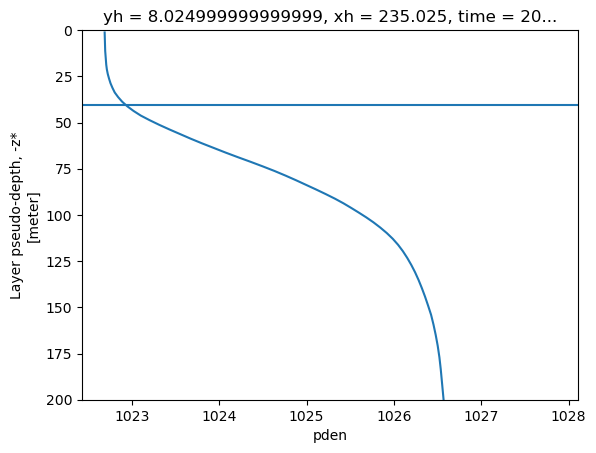

In [99]:
import etpac
import matplotlib.pyplot as plt

subset = ds.pden.sel(xh=-110, yh=8, method="nearest").isel(time=10)

computed, hmxl = dask.compute(subset, etpac.calc_hmxl(subset))

subset.plot(y="zl", ylim=(200, 0))
plt.axhline(-1 * hmxl.data)

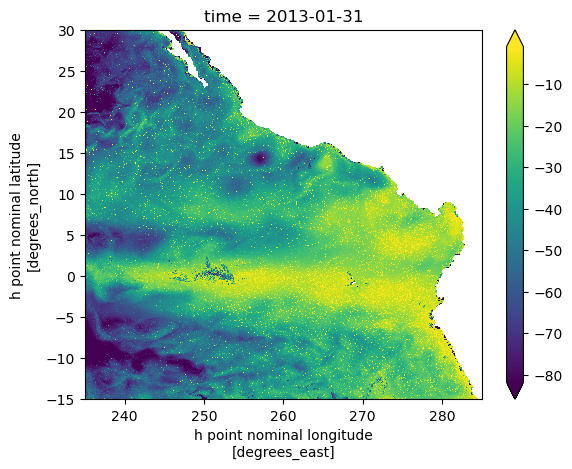

In [100]:
(
    etpac.calc_hmxl(ds.pden) # complicated but fast numba computation
    .resample(time="M").mean() # monthly mean
    .isel(time=0) # pick jan
    .plot(robust=True) # plot
)

## Also advanced: xr.map_blocks

In [105]:
def plot(temp: xr.DataArray):
    
    """ makes an sst plot from temp, which is an xarray object"""
    import matplotlib.pyplot as plt
    
    # this is xarray / matplotlib code
    # temp is an xarray object
    f, ax = plt.subplots(1, 1)
    temp.squeeze().plot()
    
    f.savefig(f"/glade/scratch/dcherian/etpac-sst/{temp.time.squeeze().values}.png")
    plt.close(f)
    
    
    # could be pandas code after a da.to_dataframe()
    # e.g. use seaborn
    
    return temp.time

<xarray.DataArray 'time' ()>
array('2013-01-01T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    zl       float64 1.25
    time     datetime64[ns] 2013-01-01T12:00:00

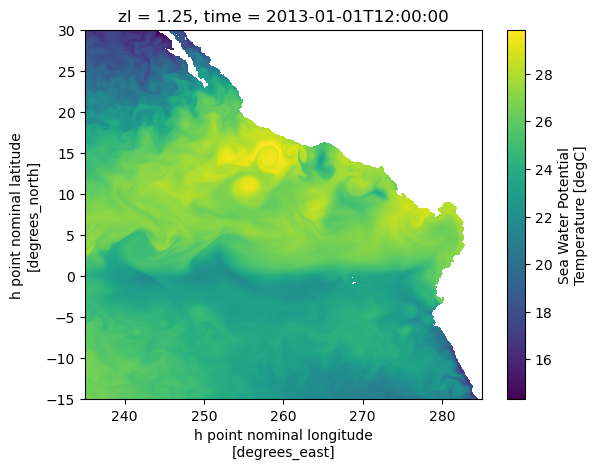

In [104]:
plot(ds.thetao.isel(zl=0, time=0))

In [118]:
ls /glade/scratch/dcherian/etpac-sst/

2013-01-05T12:00:00.000000000.png  2013-07-14T12:00:00.000000000.png
2013-01-08T12:00:00.000000000.png  2013-07-17T12:00:00.000000000.png
2013-01-11T12:00:00.000000000.png  2013-07-24T12:00:00.000000000.png
2013-01-13T12:00:00.000000000.png  2013-08-01T12:00:00.000000000.png
2013-01-18T12:00:00.000000000.png  2013-08-09T12:00:00.000000000.png
2013-01-20T12:00:00.000000000.png  2013-08-15T12:00:00.000000000.png
2013-01-22T12:00:00.000000000.png  2013-08-16T12:00:00.000000000.png
2013-01-24T12:00:00.000000000.png  2013-08-20T12:00:00.000000000.png
2013-01-28T12:00:00.000000000.png  2013-08-24T12:00:00.000000000.png
2013-02-05T12:00:00.000000000.png  2013-09-01T12:00:00.000000000.png
2013-02-08T12:00:00.000000000.png  2013-09-05T12:00:00.000000000.png
2013-02-13T12:00:00.000000000.png  2013-09-06T12:00:00.000000000.png
2013-02-14T12:00:00.000000000.png  2013-09-07T12:00:00.000000000.png
2013-02-16T12:00:00.000000000.png  2013-09-12T12:00:00.000000000.png
2013-02-17T12:00:00.000000000.png 

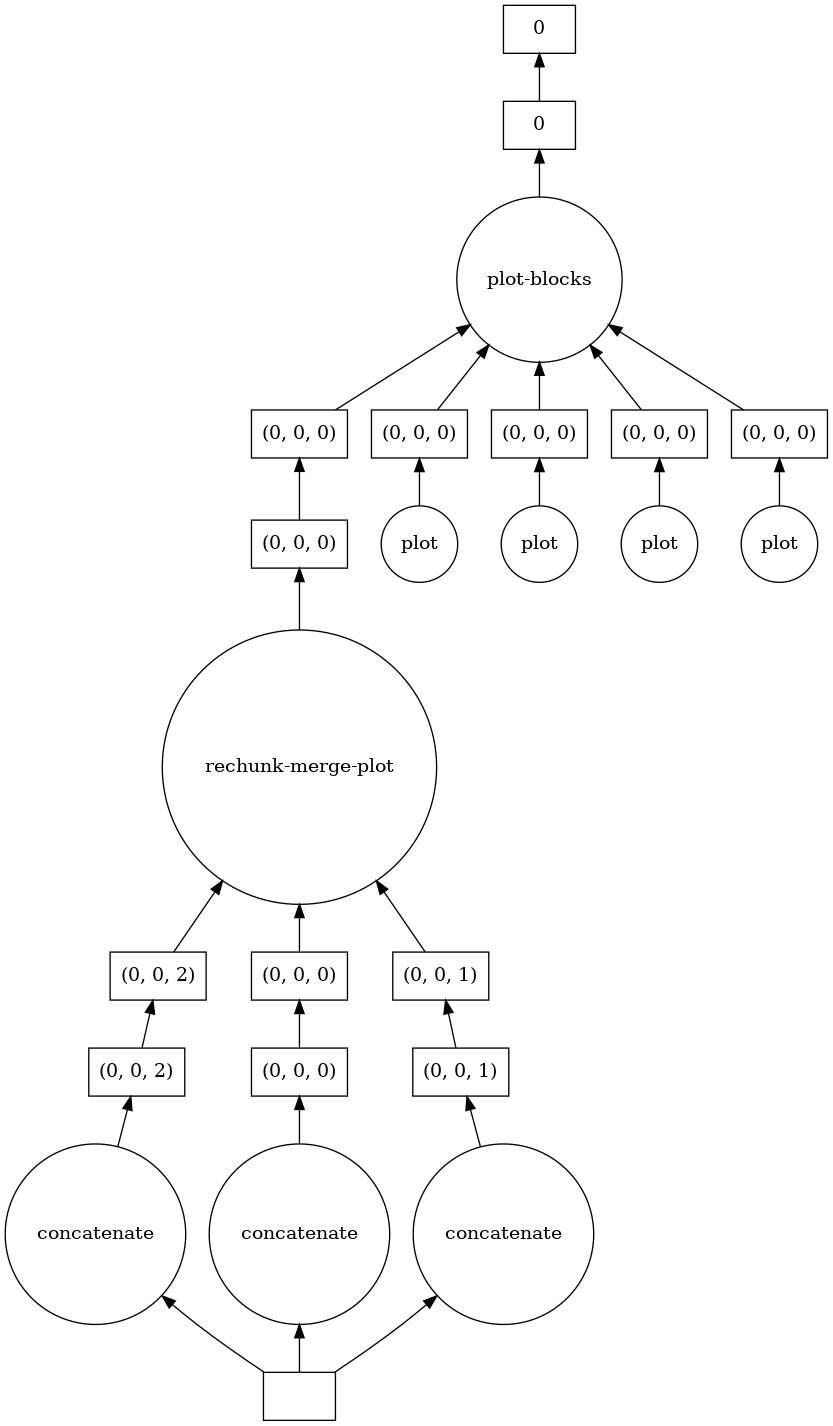

In [109]:
mapped = (
    ds.thetao.isel(zl=0)  # sea surface temperature
    .chunk({"time": 1, "xh": -1, "yh": -1})  # rechunk to one block per timestep
    .map_blocks(plot)  # apply function plot
)

mapped.data.blocks[0].visualize(optimize_graph=True)
# mapped.compute()

### Cheat by using LocalCluster :(

In [110]:
lcluster = distributed.LocalCluster(processes=1, threads_per_worker=1)
lcluster.scale(4)
lcluster

/glade/u/home/dcherian/miniconda3/envs/coiled/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40198 instead
  warnings.warn(


bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PULL-DOC-REQ' content: {} 
 error: TypeError('Object of type function is not JSON serializable')
Traceback (most recent call last):
  File "/glade/u/home/dcherian/miniconda3/envs/coiled/lib/python3.8/site-packages/bokeh/server/protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "/glade/u/home/dcherian/miniconda3/envs/coiled/lib/python3.8/site-packages/bokeh/server/session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "/glade/u/home/dcherian/miniconda3/envs/coiled/lib/python3.8/site-packages/bokeh/server/session.py", line 232, in _handle_pull
    return connection.protocol.create('PULL-DOC-REPLY', message.header['msgid'], self.document)
  File "/glade/u/home/dcherian/miniconda3/envs/coiled/lib/python3.8/site-packages/bokeh/protocol/__init__.py", line 85, in create
    return self._messages[msgtype].create(*args, **kwa

In [111]:
local = distributed.Client(lcluster)
local

Client Scheduler: tcp://127.0.0.1:40878 Dashboard: /proxy/40198/status,Cluster Workers: 4 Cores: 4 Memory: 274.88 GB


In [112]:
mapped

<xarray.DataArray 'time' (time: 365)>
dask.array<plot-20ace22f9d5e187bd89380bb790cdf7d-<this, shape=(365,), dtype=datetime64[ns], chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01T12:00:00 ... 2013-12-31T12:00:00
    zl       float64 dask.array<chunksize=(), meta=np.ndarray>

In [113]:
mapped.persist(scheduler=local)

<xarray.DataArray 'time' (time: 365)>
dask.array<plot-20ace22f9d5e187bd89380bb790cdf7d-<this, shape=(365,), dtype=datetime64[ns], chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01T12:00:00 ... 2013-12-31T12:00:00
    zl       float64 dask.array<chunksize=(), meta=np.ndarray>